# Digit Recognition using MLP in PyTorch

In this competition, our goal is to correctly identify digits from a dataset of tens of thousands of handwritten images using custom multi-layered perceptron.

## 1. Importing Libraries
---

In [1]:
#Importing all libraries
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torch.autograd import Variable

import time
import helper
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

## 2. Importing Dataset
---

In [2]:
#Import data
train_df = pd.read_csv('../input/digit-recognizer/train.csv')
test_df = pd.read_csv('../input/digit-recognizer/test.csv')

## 3. Train and Validation datasets
---
Splitting dataset into train and validation. Also converting them to float values.

In [3]:
#Labels(Targets) and Inputs
train_labels = train_df['label'].values
train_images = (train_df.iloc[:,1:].values).astype('float32')
test_images = (test_df.iloc[:,:].values).astype('float32')

#Training and Validation Split
train_images, val_images, train_labels, val_labels = train_test_split(train_images, 
                                                                      train_labels,
                                                                      stratify=train_labels, 
                                                                      random_state=302,
                                                                      test_size=0.2)

## 4. Reshaping the data to make Tensors
---

In [4]:
#train
train_images_tensor = torch.tensor(train_images)/255.0
train_labels_tensor = torch.tensor(train_labels)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)
#val
val_images_tensor = torch.tensor(val_images)/255.0
val_labels_tensor = torch.tensor(val_labels)
val_tensor = TensorDataset(val_images_tensor, val_labels_tensor)
#test
test_images_tensor = torch.tensor(test_images)/255.0

In [5]:
#View Tensor shapes 
train_images_tensor.shape, train_labels_tensor.shape 

(torch.Size([33600, 784]), torch.Size([33600]))

## 5. Viewing the Images
---

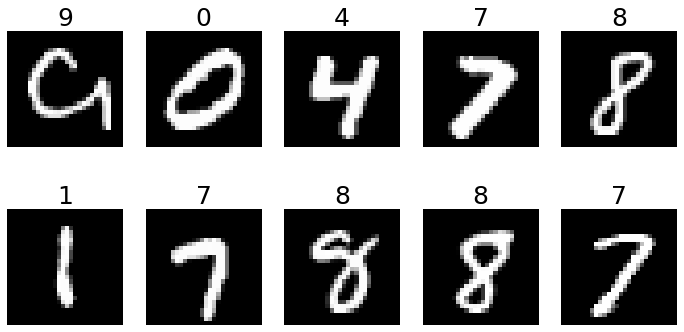

In [6]:
fig, axes = plt.subplots(2,5, figsize=(12,6))
axes = axes.flatten()
idx = np.random.randint(0,5000,size=10)
for i in range(10):
    axes[i].imshow(train_images[idx[i],:].reshape(28,28), cmap='gray')
    axes[i].axis('off') # hide the axes ticks
    axes[i].set_title(str(int(train_labels[idx[i]])), color= 'black', fontsize=25)
plt.show()

## 6. Feeding tensors to data loader
---

In [7]:
#Dataloader
train_loader = DataLoader(train_tensor, batch_size = 64, num_workers=2, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size = 64, num_workers=2, shuffle=True)
test_loader = DataLoader(test_images_tensor, batch_size = 32, num_workers=2, shuffle=False)

In [8]:
len(train_loader)

525

## 7. Defining Model Architecture
---

In [9]:
model = nn.Sequential(nn.Linear(784, 512),
                      nn.LeakyReLU(),
                      nn.Linear(512, 256),
                      nn.BatchNorm1d(256),
                      nn.LeakyReLU(),
                      nn.Linear(256, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )
device

device(type='cuda')

In [10]:
model.to(device)
model

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.01)
  (5): Linear(in_features=256, out_features=10, bias=True)
  (6): LogSoftmax(dim=1)
)

## 8. Functions for training and evaluation
---

In [11]:
from utility import train_model, cal_accuracy

## 9. Training the model over train dataset
---

In [12]:
train_l, valid_l, train_a, valid_a= train_model(model, 20, train_loader, val_loader, 
            optimizer, criterion, device, model_save=True, model_name="model.pt")

Epoch: 1 	Training Loss: 0.020788 	Validation Loss: 0.012994
Validation loss decreased (inf --> 0.012994).  Saving model ...
Epoch: 2 	Training Loss: 0.010866 	Validation Loss: 0.009041
Validation loss decreased (0.012994 --> 0.009041).  Saving model ...
Epoch: 3 	Training Loss: 0.008085 	Validation Loss: 0.007061
Validation loss decreased (0.009041 --> 0.007061).  Saving model ...
Epoch: 4 	Training Loss: 0.006538 	Validation Loss: 0.005877
Validation loss decreased (0.007061 --> 0.005877).  Saving model ...
Epoch: 5 	Training Loss: 0.005517 	Validation Loss: 0.005019
Validation loss decreased (0.005877 --> 0.005019).  Saving model ...
Epoch: 6 	Training Loss: 0.004754 	Validation Loss: 0.004408
Validation loss decreased (0.005019 --> 0.004408).  Saving model ...
Epoch: 7 	Training Loss: 0.004139 	Validation Loss: 0.003930
Validation loss decreased (0.004408 --> 0.003930).  Saving model ...
Epoch: 8 	Training Loss: 0.003649 	Validation Loss: 0.003583
Validation loss decreased (0.00393

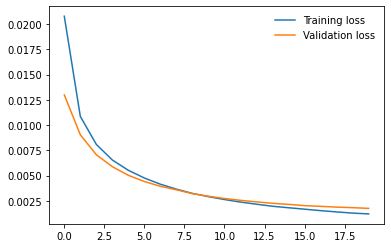

In [13]:
plt.plot(train_l, label='Training loss')
plt.plot(valid_l, label='Validation loss')
plt.legend(frameon=False)

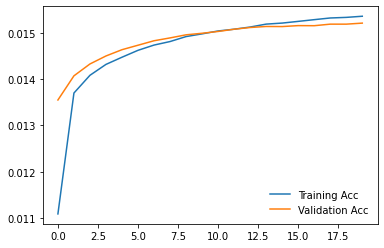

In [14]:
plt.plot(train_a, label='Training Acc')
plt.plot(valid_a, label='Validation Acc')
plt.legend(frameon=False)

## 10. Loading the saved model
---

In [15]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

## 11. Prediction
---

In [16]:
def make_predictions(data_loader):
    model.eval()
    test_preds = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = data.view(-1, 28*28).to(device)
        output = model(data)
        preds = output.data.max(1, keepdim=True)[1]
        test_preds = torch.cat((test_preds.to(device), preds.to(device)), dim=0)
    return test_preds

In [17]:
test_set_preds = make_predictions(test_loader)

## 12. Submission
---

In [18]:
sub = pd.read_csv("../input/digit-recognizer/sample_submission.csv")
sub['Label'] = test_set_preds.cpu().numpy().squeeze()
sub.to_csv("MLP#1.csv", index=False)
sub.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,4
4,5,3


# Thank you!

Author: Pratik Kumar